In [110]:
import requests 
from bs4 import BeautifulSoup
import pickle 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
import pandas as pd
from nltk import word_tokenize, pos_tag
import re
from textblob import TextBlob
import numpy as np
import string
from gensim import matutils, models
import scipy.sparse
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter

In [2]:
# Data
# URLs of transcripts in scope
urls = ['http://scrapsfromtheloft.com/2017/05/06/louis-ck-oh-my-god-full-transcript/',
        'http://scrapsfromtheloft.com/2017/04/11/dave-chappelle-age-spin-2017-full-transcript/',
        'http://scrapsfromtheloft.com/2018/03/15/ricky-gervais-humanity-transcript/',
        'http://scrapsfromtheloft.com/2017/08/07/bo-burnham-2013-full-transcript/',
        'http://scrapsfromtheloft.com/2017/05/24/bill-burr-im-sorry-feel-way-2014-full-transcript/',
        'http://scrapsfromtheloft.com/2017/04/21/jim-jefferies-bare-2014-full-transcript/',
        'http://scrapsfromtheloft.com/2017/08/02/john-mulaney-comeback-kid-2015-full-transcript/',
        'http://scrapsfromtheloft.com/2017/10/21/hasan-minhaj-homecoming-king-2017-full-transcript/',
        'http://scrapsfromtheloft.com/2017/09/19/ali-wong-baby-cobra-2016-full-transcript/',
        'http://scrapsfromtheloft.com/2017/08/03/anthony-jeselnik-thoughts-prayers-2015-full-transcript/',
        'http://scrapsfromtheloft.com/2018/03/03/mike-birbiglia-my-girlfriends-boyfriend-2013-full-transcript/',
        'http://scrapsfromtheloft.com/2017/08/19/joe-rogan-triggered-2016-full-transcript/']

# Comedian names
comedians = ['louis', 'dave', 'ricky', 'bo', 'bill', 'jim', 'john', 'hasan', 'ali', 'anthony', 'mike', 'joe']


In [3]:
def url_to_transcript(url):
    '''Returns transcript data specifically from scrapsfromtheloft.com.'''
    page = requests.get(url).text
    soup = BeautifulSoup(page, "html")
    text = [p.text for p in soup.find(class_="post-content").find_all('p')]
    print(url)
    return text

In [4]:
data = [url_to_transcript(i) for i in urls]

http://scrapsfromtheloft.com/2017/05/06/louis-ck-oh-my-god-full-transcript/
http://scrapsfromtheloft.com/2017/04/11/dave-chappelle-age-spin-2017-full-transcript/
http://scrapsfromtheloft.com/2018/03/15/ricky-gervais-humanity-transcript/
http://scrapsfromtheloft.com/2017/08/07/bo-burnham-2013-full-transcript/
http://scrapsfromtheloft.com/2017/05/24/bill-burr-im-sorry-feel-way-2014-full-transcript/
http://scrapsfromtheloft.com/2017/04/21/jim-jefferies-bare-2014-full-transcript/
http://scrapsfromtheloft.com/2017/08/02/john-mulaney-comeback-kid-2015-full-transcript/
http://scrapsfromtheloft.com/2017/10/21/hasan-minhaj-homecoming-king-2017-full-transcript/
http://scrapsfromtheloft.com/2017/09/19/ali-wong-baby-cobra-2016-full-transcript/
http://scrapsfromtheloft.com/2017/08/03/anthony-jeselnik-thoughts-prayers-2015-full-transcript/
http://scrapsfromtheloft.com/2018/03/03/mike-birbiglia-my-girlfriends-boyfriend-2013-full-transcript/
http://scrapsfromtheloft.com/2017/08/19/joe-rogan-triggered-

In [5]:
print(data[0][2])

“My Daughter Likes Fish”
You ever flush a pet down the toilet? I had to flush my daughter’s fish down the toilet. I came home, the fish was dead. She wasn’t home from school yet, so I just flushed the fish, And that’s a weird moment, too, ’cause fish live in water. So you put it in the toilet, floats to the bottom, Like, “yeah, he’s dead,” And then you flush, and it looks like he goes, “wait a second! Aw, shit! “I was taking a nap! Jesus! “you gotta be in constant motion To get any respect in this house.” And then my daughter comes home. “why did he die, da–” Come on. What am I gonna say? Why did he die? Because who gives a shit? That’s the reason. That’s the actual reason, is because didn’t matter That he was alive. That’s why he’s dead. He didn’t know his name, and he didn’t love you back. These are the facts about that fish’s life. My daughter likes fish. We took her to the aquarium. I took both my kids to the aquarium in boston, And we were looking at this seal, or sea lion. I don’

In [6]:

df = pd.DataFrame()
df['Comedian'] = comedians
df['Transcripts'] = data
df.to_csv("Transcripts.csv",index=False)

In [7]:
df

,Comedian,Transcripts
0,louis,[Intro\nFade the music out. Let’s roll. Hold t...
1,dave,[This is Dave. He tells dirty jokes for a livi...
2,ricky,[Hello. Hello! How you doing? Great. Thank you...
3,bo,[Bo What? Old MacDonald had a farm E I E I O A...
4,bill,"[[cheers and applause] All right, thank you! T..."
5,jim,[[Car horn honks] [Audience cheering] [Announc...
6,john,"[All right, Petunia. Wish me luck out there. Y..."
7,hasan,[[theme music: orchestral hip-hop] [crowd roar...
8,ali,"[Ladies and gentlemen, please welcome to the s..."
9,anthony,"[Thank you. Thank you. Thank you, San Francisc..."


In [8]:
df['Transcripts'] = df['Transcripts'].apply(lambda x : ' '.join(x))

In [9]:
df.head()

,Comedian,Transcripts
0,louis,Intro\nFade the music out. Let’s roll. Hold th...
1,dave,This is Dave. He tells dirty jokes for a livin...
2,ricky,Hello. Hello! How you doing? Great. Thank you....
3,bo,Bo What? Old MacDonald had a farm E I E I O An...
4,bill,"[cheers and applause] All right, thank you! Th..."


In [10]:
df[df['Comedian'] == 'ali']['Transcripts']

8    Ladies and gentlemen, please welcome to the st...
Name: Transcripts, dtype: object

In [11]:
# Clean Data
df['Transcripts'] = df.Transcripts.apply(lambda x: re.sub(r'\[.*?\]|[%s]|\w*\d\w*|\n|[‘’“”…]'\
                                                                  % re.escape(string.punctuation), '',x).lower())

In [12]:
df.set_index('Comedian',inplace=True)
df.head()

,Transcripts
Comedian,
louis,introfade the music out lets roll hold there l...
dave,this is dave he tells dirty jokes for a living...
ricky,hello hello how you doing great thank you wow ...
bo,bo what old macdonald had a farm e i e i o and...
bill,all right thank you thank you very much thank...


In [13]:
cv = CountVectorizer(stop_words='english')

In [14]:
data_cv = cv.fit_transform(df['Transcripts'])

In [15]:
data2 = pd.DataFrame(data_cv.toarray(),columns=cv.get_feature_names())
data2.index = df.index

In [16]:
# Document word matrix format
data2

,aaaaah,aaaaahhhhhhh,aaaaauuugghhhhhh,aaaahhhhh,aaah,aah,abc,abcs,ability,abject,...,zee,zen,zeppelin,zero,zillion,zombie,zombies,zoning,zoo,éclair
Comedian,,,,,,,,,,,,,,,,,,,,,
louis,0,0,0,0,0,3,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
dave,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ricky,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
bo,0,1,1,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
bill,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,1,1,1,1,0,0
jim,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
john,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
hasan,0,0,0,0,0,0,0,0,0,0,...,2,1,0,1,0,0,0,0,0,0
ali,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [17]:
with open('cv.pkl','wb') as f:
    pickle.dump(cv,f)

# EDA 
##### Exploratory Data Analysis
 - Top words
 - Lexicon
 - Swearing

In [18]:
dt = data2.transpose()
dt

Comedian,louis,dave,ricky,bo,bill,jim,john,hasan,ali,anthony,mike,joe
aaaaah,0,0,0,0,1,0,0,0,0,0,0,0
aaaaahhhhhhh,0,0,0,1,0,0,0,0,0,0,0,0
aaaaauuugghhhhhh,0,0,0,1,0,0,0,0,0,0,0,0
aaaahhhhh,0,0,0,1,0,0,0,0,0,0,0,0
aaah,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
zombie,0,0,0,0,1,0,0,0,1,0,0,0
zombies,0,0,0,0,1,0,0,0,0,0,0,0
zoning,0,0,0,0,1,0,0,0,0,0,0,0
zoo,0,0,1,0,0,0,0,0,0,0,0,0


In [19]:
word_frequency = {}
for i in tqdm(dt.columns):
    word_count = dt[i].sort_values(ascending=False).head(30)
    word_frequency[i] = list(zip(word_count.index, word_count.values))


100%|██████████| 12/12 [00:00<00:00, 374.65it/s]


In [20]:
word_frequency['louis']

[('like', 110),
 ('just', 97),
 ('know', 70),
 ('dont', 53),
 ('thats', 51),
 ('im', 50),
 ('youre', 50),
 ('life', 41),
 ('people', 40),
 ('thing', 31),
 ('hes', 29),
 ('gonna', 29),
 ('theres', 28),
 ('cause', 28),
 ('shit', 25),
 ('time', 22),
 ('tit', 22),
 ('good', 22),
 ('theyre', 21),
 ('think', 21),
 ('right', 21),
 ('really', 20),
 ('course', 19),
 ('kids', 18),
 ('guy', 18),
 ('murder', 18),
 ('ok', 17),
 ('old', 15),
 ('didnt', 15),
 ('mean', 15)]

In [21]:
word_count = pd.DataFrame(list(word_frequency.items()))

In [22]:
word_count

,0,1
0,louis,"[(like, 110), (just, 97), (know, 70), (dont, 5..."
1,dave,"[(like, 103), (know, 79), (said, 63), (just, 6..."
2,ricky,"[(right, 110), (like, 80), (im, 66), (just, 66..."
3,bo,"[(know, 50), (like, 44), (love, 37), (im, 37),..."
4,bill,"[(like, 200), (just, 149), (right, 131), (im, ..."
5,jim,"[(like, 108), (im, 101), (dont, 90), (right, 8..."
6,john,"[(like, 190), (know, 66), (just, 53), (dont, 5..."
7,hasan,"[(like, 220), (im, 136), (know, 70), (dont, 64..."
8,ali,"[(like, 126), (im, 74), (know, 65), (just, 64)..."
9,anthony,"[(im, 60), (like, 50), (know, 39), (dont, 38),..."


In [23]:
words = []
for comedian in data2.index:
    top = [word for (word,_) in word_frequency[comedian]]
    for i in top:
        words.append(i)
print(len(words))

360


In [88]:
new_stop = [words for (words,count) in Counter(words).most_common() if count > 6]
new_stop += ['going','fuck','fucking']

In [89]:
# things to remove 
stopper = text.ENGLISH_STOP_WORDS.union(new_stop)
cv = CountVectorizer(stop_words=stopper)
with open('cv_stopper.pkl','wb') as f:
    pickle.dump(cv, f)
dwmf = cv.fit_transform(df['Transcripts'])
df_dwm = pd.DataFrame(dwmf.toarray(), columns=cv.get_feature_names())
df_dwm.index = df.index

In [90]:
df_dwmt = df_dwm.transpose()
df_dwmt

Comedian,louis,dave,ricky,bo,bill,jim,john,hasan,ali,anthony,mike,joe
aaaaah,0,0,0,0,1,0,0,0,0,0,0,0
aaaaahhhhhhh,0,0,0,1,0,0,0,0,0,0,0,0
aaaaauuugghhhhhh,0,0,0,1,0,0,0,0,0,0,0,0
aaaahhhhh,0,0,0,1,0,0,0,0,0,0,0,0
aaah,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
zombie,0,0,0,0,1,0,0,0,1,0,0,0
zombies,0,0,0,0,1,0,0,0,0,0,0,0
zoning,0,0,0,0,1,0,0,0,0,0,0,0
zoo,0,0,1,0,0,0,0,0,0,0,0,0


In [91]:
nword_frequency = {}
for i in tqdm(df_dwmt.columns):
    word_count = df_dwmt[i].sort_values(ascending=False).head(20)
    nword_frequency[i] = list(zip(word_count.index, word_count.values))

100%|██████████| 12/12 [00:00<00:00, 299.59it/s]


In [92]:
nword_frequency

{'louis': [('life', 41),
  ('thing', 31),
  ('hes', 29),
  ('theres', 28),
  ('cause', 28),
  ('shit', 25),
  ('good', 22),
  ('tit', 22),
  ('theyre', 21),
  ('really', 20),
  ('course', 19),
  ('murder', 18),
  ('guy', 18),
  ('kids', 18),
  ('ok', 17),
  ('didnt', 15),
  ('mean', 15),
  ('old', 15),
  ('way', 14),
  ('happened', 13)],
 'dave': [('shit', 45),
  ('didnt', 39),
  ('ahah', 38),
  ('black', 31),
  ('man', 30),
  ('good', 27),
  ('lot', 20),
  ('nigga', 20),
  ('gay', 20),
  ('did', 19),
  ('hes', 19),
  ('oh', 18),
  ('oj', 18),
  ('come', 17),
  ('guys', 16),
  ('kevin', 16),
  ('remember', 15),
  ('dave', 15),
  ('looked', 15),
  ('whats', 15)],
 'ricky': [('say', 43),
  ('went', 40),
  ('id', 39),
  ('didnt', 33),
  ('little', 32),
  ('joke', 31),
  ('hes', 29),
  ('theyre', 29),
  ('ive', 28),
  ('thing', 26),
  ('years', 24),
  ('day', 23),
  ('saying', 22),
  ('theres', 22),
  ('hed', 21),
  ('ill', 21),
  ('big', 21),
  ('come', 19),
  ('god', 19),
  ('mean', 19)]

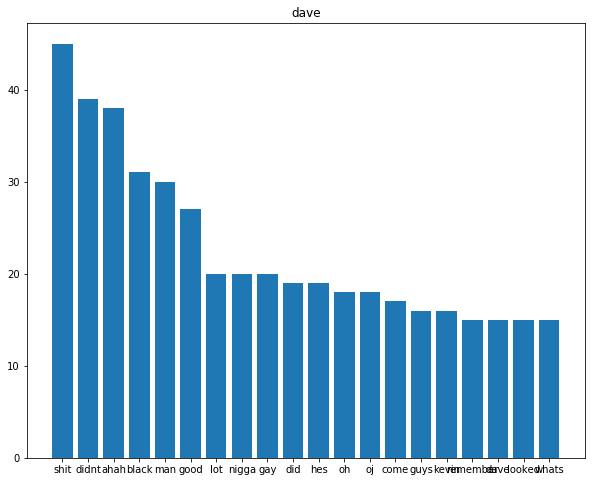

In [93]:
i = 'dave'
D = dict(nword_frequency[i])
plt.title(i)
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

In [94]:
total_words = []
for i in df_dwmt.columns:
    tot = sum(df_dwmt[i])
    total_words.append(tot)
unique = []
for i in df_dwmt.columns:
    tot = df_dwmt[i].to_numpy().nonzero()[0].size
    unique.append(tot)

In [95]:
df['total_words'] = total_words
df['unique'] = unique

# Sentiment Analysis

In [96]:
for i in df.index:
    print(i.upper(),"polarity:",TextBlob(df['Transcripts'][i]).polarity)
    print(i.upper(),"subjectivity:",TextBlob(df['Transcripts'][i]).subjectivity)

LOUIS polarity: 0.051625754492421225
LOUIS subjectivity: 0.5238583685861466
DAVE polarity: -0.005095077079697494
DAVE subjectivity: 0.5158157443923156
RICKY polarity: 0.052854441603229045
RICKY subjectivity: 0.5083000505260443
BO polarity: 0.07369476873100066
BO subjectivity: 0.5539205708408614
BILL polarity: 0.008256529651038314
BILL subjectivity: 0.543995518771531
JIM polarity: 0.038131392156583725
JIM subjectivity: 0.538652713964872
JOHN polarity: 0.07463805535438779
JOHN subjectivity: 0.49143369206406406
HASAN polarity: 0.08018048449866627
HASAN subjectivity: 0.46412127969979233
ALI polarity: 0.06676468011931269
ALI subjectivity: 0.4795965877395591
ANTHONY polarity: 0.04550658962547667
ANTHONY subjectivity: 0.5659549912332374
MIKE polarity: 0.08197111580176096
MIKE subjectivity: 0.5261978344236414
JOE polarity: 0.005476058402313635
JOE subjectivity: 0.5566260372588823


In [97]:
df['polarity'] = df['Transcripts'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['Transcripts'].apply(lambda x: TextBlob(x).sentiment.subjectivity)
df['name'] = df.index
df

,Transcripts,total_words,unique,polarity,subjectivity,name
Comedian,,,,,,
louis,introfade the music out lets roll hold there l...,2664,1081,0.051626,0.523858,louis
dave,this is dave he tells dirty jokes for a living...,3398,1387,-0.005095,0.515816,dave
ricky,hello hello how you doing great thank you wow ...,4152,1615,0.052854,0.508300,ricky
bo,bo what old macdonald had a farm e i e i o and...,2728,1255,0.073695,0.553921,bo
bill,all right thank you thank you very much thank...,4193,1617,0.008257,0.543996,bill
jim,ladies and gentlemen please welcome to the ...,3829,1295,0.038131,0.538653,jim
john,all right petunia wish me luck out there you w...,3347,1374,0.074638,0.491434,john
hasan,whats up davis whats up im home i had to bri...,3938,1544,0.080180,0.464121,hasan
ali,ladies and gentlemen please welcome to the sta...,2682,1326,0.066765,0.479597,ali


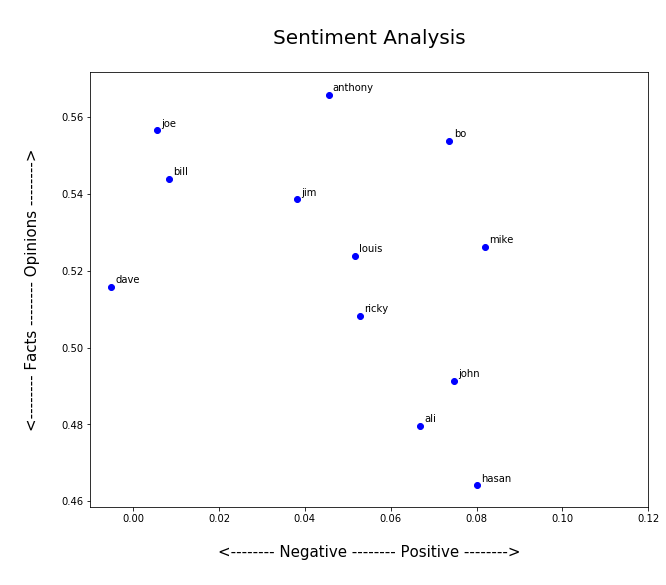

In [98]:
plt.rcParams['figure.figsize'] = [10, 8]

for index, comedian in enumerate(df.index):
    x = df.polarity.loc[comedian]
    y = df.subjectivity.loc[comedian]
    plt.scatter(x, y, color='blue')
    plt.text(x+.001, y+.001, df['name'][index], fontsize=10)
    plt.xlim(-.01, .12) 
    
plt.title('\nSentiment Analysis\n', fontsize=20)
plt.xlabel('\n<-------- Negative -------- Positive -------->\n', fontsize=15)
plt.ylabel('\n<-------- Facts -------- Opinions -------->\n', fontsize=15)

plt.show()

# Topic Modelling 

In [99]:
df_dwmt.head()

Comedian,louis,dave,ricky,bo,bill,jim,john,hasan,ali,anthony,mike,joe
aaaaah,0,0,0,0,1,0,0,0,0,0,0,0
aaaaahhhhhhh,0,0,0,1,0,0,0,0,0,0,0,0
aaaaauuugghhhhhh,0,0,0,1,0,0,0,0,0,0,0,0
aaaahhhhh,0,0,0,1,0,0,0,0,0,0,0,0
aaah,0,1,0,0,0,0,0,0,0,0,0,0


In [100]:
sparse_couts = scipy.sparse.csr_matrix(df_dwmt)
corpus = matutils.Sparse2Corpus(sparse_couts)

In [101]:
cv_stopper = pickle.load(open("cv_stopper.pkl","rb"))
id2word = dict((v,k) for k, v in cv.vocabulary_.items())
id2word

{3415: 'introfade',
 4340: 'music',
 3778: 'lets',
 5568: 'roll',
 3137: 'hold',
 3815: 'lights',
 6659: 'thank',
 283: 'appreciate',
 4399: 'necessarily',
 118: 'agree',
 4443: 'nice',
 4917: 'place',
 2097: 'easily',
 4444: 'nicest',
 4173: 'miles',
 1879: 'direction',
 1390: 'compliment',
 867: 'building',
 5908: 'shit',
 6810: 'town',
 5829: 'sentence',
 4539: 'odd',
 2033: 'driving',
 1952: 'doesnt',
 1857: 'difference',
 5972: 'sidewalk',
 6384: 'street',
 4789: 'pedestrians',
 3630: 'kind',
 7169: 'walk',
 4164: 'middle',
 5549: 'road',
 3907: 'love',
 6853: 'traveling',
 5787: 'seeing',
 1859: 'different',
 4742: 'parts',
 1524: 'country',
 3842: 'live',
 4434: 'new',
 7442: 'york',
 6675: 'theres',
 7073: 'value',
 1957: 'doing',
 4562: 'old',
 3680: 'lady',
 1954: 'dogi',
 4412: 'neighborhood',
 5901: 'shes',
 7171: 'walking',
 1953: 'dog',
 6280: 'stands',
 2466: 'fights',
 2870: 'gravity',
 1707: 'day',
 5327: 'really',
 1955: 'dogs',
 1285: 'cloudy',
 2346: 'eye',
 6277: '

In [103]:
lda = models.LdaModel(corpus=corpus, id2word=id2word, num_topics=12, passes=10)
lda.print_topics()

[(0,
  '0.000*"shit" + 0.000*"say" + 0.000*"didnt" + 0.000*"dad" + 0.000*"way" + 0.000*"theyre" + 0.000*"hes" + 0.000*"good" + 0.000*"oh" + 0.000*"cause"'),
 (1,
  '0.011*"says" + 0.008*"cause" + 0.008*"jenny" + 0.007*"goes" + 0.007*"really" + 0.007*"id" + 0.006*"mean" + 0.006*"point" + 0.005*"kind" + 0.005*"uh"'),
 (2,
  '0.011*"shit" + 0.009*"didnt" + 0.009*"ahah" + 0.008*"man" + 0.007*"black" + 0.007*"good" + 0.005*"oh" + 0.005*"lot" + 0.005*"did" + 0.005*"gay"'),
 (3,
  '0.013*"shit" + 0.008*"dude" + 0.007*"want" + 0.006*"did" + 0.006*"hes" + 0.006*"guy" + 0.006*"didnt" + 0.006*"make" + 0.006*"come" + 0.005*"thing"'),
 (4,
  '0.000*"cause" + 0.000*"want" + 0.000*"oh" + 0.000*"says" + 0.000*"really" + 0.000*"didnt" + 0.000*"say" + 0.000*"id" + 0.000*"mean" + 0.000*"shit"'),
 (5,
  '0.006*"day" + 0.006*"say" + 0.005*"little" + 0.005*"oh" + 0.005*"love" + 0.004*"did" + 0.004*"shit" + 0.004*"good" + 0.004*"really" + 0.004*"guys"'),
 (6,
  '0.010*"theyre" + 0.010*"shit" + 0.009*"life" +

In [111]:
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)

In [112]:
df = pd.DataFrame(df.Transcripts.apply(nouns_adj))
data_nouns = df
data_nouns

,Transcripts
Comedian,
louis,music lets lights lights thank much i i i nice...
dave,dirty jokes living stare most hard work profou...
ricky,hello great thank fuck thank lovely welcome im...
bo,old macdonald farm e i i o farm pig e i i snor...
bill,right thank thank pleasure greater atlanta geo...
jim,ladies gentlemen welcome stage mr jim jefferie...
john,right petunia august thats good right hello he...
hasan,whats davis whats im home i netflix special la...
ali,ladies gentlemen welcome stage ali wong hi wel...


In [114]:
# Re-add the additional stop words since we are recreating the document-term matrix
add_stop_words = ['like', 'im', 'know', 'just', 'dont', 'thats', 'right', 'people',
                  'youre', 'got', 'gonna', 'time', 'think', 'yeah', 'said']
stop_words = text.ENGLISH_STOP_WORDS.union(add_stop_words)

# Recreate a document-term matrix with only nouns
cvn = CountVectorizer(stop_words=stop_words)
data_cvn = cvn.fit_transform(data_nouns.Transcripts)
data_dtmn = pd.DataFrame(data_cvn.toarray(), columns=cvn.get_feature_names())
data_dtmn.index = data_nouns.index
data_dtmn

,aaaaah,aaaaahhhhhhh,aaaaauuugghhhhhh,aaaahhhhh,aah,abc,abcs,ability,abject,able,...,ze,zealand,zee,zeppelin,zero,zillion,zombie,zombies,zoo,éclair
Comedian,,,,,,,,,,,,,,,,,,,,,
louis,0,0,0,0,3,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
dave,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ricky,0,0,0,0,0,0,0,1,1,2,...,0,0,0,0,0,0,0,0,1,0
bo,0,1,1,1,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
bill,1,0,0,0,0,0,1,0,0,1,...,1,0,0,0,0,1,1,1,0,0
jim,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
john,0,0,0,0,0,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,1
hasan,0,0,0,0,0,0,0,0,0,1,...,0,0,2,0,0,0,0,0,0,0
ali,0,0,0,0,0,1,0,0,0,2,...,0,0,0,0,0,0,1,0,0,0


In [124]:
# Create the gensim corpus
corpusn = matutils.Sparse2Corpus(scipy.sparse.csr_matrix(data_dtmn.transpose()))
# Create the vocabulary dictionary
id2wordn = dict((v, k) for k, v in cvn.vocabulary_.items())

In [125]:
ldan = models.LdaModel(corpus=corpusn, num_topics=4, id2word=id2wordn, passes=10)
ldan.print_topics()

[(0,
  '0.013*"life" + 0.010*"thing" + 0.008*"hes" + 0.007*"good" + 0.007*"cause" + 0.007*"tit" + 0.006*"shit" + 0.006*"course" + 0.006*"kids" + 0.005*"guy"'),
 (1,
  '0.009*"thing" + 0.009*"day" + 0.008*"little" + 0.007*"fucking" + 0.007*"shit" + 0.007*"ive" + 0.006*"hes" + 0.006*"fuck" + 0.006*"guy" + 0.006*"theyre"'),
 (2,
  '0.010*"shit" + 0.009*"fuck" + 0.009*"man" + 0.007*"good" + 0.006*"lot" + 0.005*"fucking" + 0.005*"white" + 0.005*"theyre" + 0.005*"little" + 0.005*"hes"'),
 (3,
  '0.008*"dad" + 0.007*"day" + 0.006*"good" + 0.006*"way" + 0.006*"hey" + 0.005*"mom" + 0.005*"school" + 0.005*"cause" + 0.005*"little" + 0.005*"thing"')]

In [121]:
corpus_transformed = ldan[corpusn]
list(zip([a for [(a,b)] in corpus_transformed], data_dtmn.index))

[(0, 'louis'),
 (2, 'dave'),
 (1, 'ricky'),
 (1, 'bo'),
 (0, 'bill'),
 (0, 'jim'),
 (0, 'john'),
 (0, 'hasan'),
 (0, 'ali'),
 (0, 'anthony'),
 (3, 'mike'),
 (0, 'joe')]